In [1]:
import os
import torch
import dgl
from sklearn import cluster
import matplotlib.pyplot as plt
from dgl.nn import GraphConv,GATConv,SAGEConv
import torch.nn as nn
import torch.nn.functional as F
import os 
import pickle
import numpy as n
from scipy import stats
from scipy.spatial.distance import cosine
import pandas as pd

In [2]:
data = open("human.txt").readlines()[1:]
data[0]

'9606.ENSP00000000233 9606.ENSP00000379496 155\n'

#protein_dict是所有出现过的gene 与编号的对应 protein 主要为interact 记录边服务

In [3]:
protein_dict = {}

id=0
for _ in data:
    pro1,pro2,score = _.split(' ')
    
    if pro1 not in protein_dict:
        protein_dict[pro1] =id 
        id+=1
    if pro2 not in protein_dict:
        protein_dict[pro2] =id
        id+=1
print(len(protein_dict))

19385


In [5]:
protein1 ,protein2 = [],[]
for tmp in data:
    pro1,pro2,score = tmp.split(' ')
    protein1.append(protein_dict[pro1])
    protein2.append(protein_dict[pro2])

In [6]:
print(len(protein1))
print(len(protein2))

11938498
11938498


In [8]:
node_len = len(protein_dict)
label = torch.zeros((node_len,))
label

tensor([0., 0., 0.,  ..., 0., 0., 0.])

记录excel表中 label为1 的编号对应的protein_dict中的id

In [9]:
data = pd.read_excel("gene.xlsx")
_ = data['id']
idx =[]
for id in _:
    if not id== '0':
        idx.append(protein_dict["9606."+str(id)])
print(idx)

[6930, 7911, 4631, 3090, 6539, 5127, 11289, 8704, 232, 6145, 4922, 4799, 2700, 5978, 14450, 10860, 337, 11307, 3344, 3876, 5595, 5105, 7680, 3726, 2963, 2604, 9266, 10774, 3372, 13142, 10486, 10436, 4866, 5774, 15379, 2511, 10808, 5450, 17249, 11961, 6055, 4316, 1707, 10522, 1418, 7367, 1497, 5734, 18204, 11719, 3499]


In [10]:
label[idx]=1
label = label.reshape(-1,1)
print(label)

tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [11]:
graph = dgl.graph((torch.tensor(protein1),torch.tensor(protein2)))
graph

Graph(num_nodes=19385, num_edges=11938498,
      ndata_schemes={}
      edata_schemes={})

In [13]:
print(graph.nodes())

tensor([    0,     1,     2,  ..., 19382, 19383, 19384])


In [14]:
print(graph.edges())

(tensor([    0,     0,     0,  ..., 18303, 18303, 18303]), tensor([    1,     2,     3,  ..., 18288, 18061, 19181]))


In [15]:
graph.ndata["label"]= label

In [16]:
dgl.save_graphs("ppi_graph",graph)

In [16]:
def read_pickle(path):
    data_list = []
    with open (path,"rb") as f:
        while True:
            try:
                data = pickle.load(f)
                data_list.append(data)
            except EOFError:
                break
    return data_list

In [17]:
data = read_pickle("9606-emb.pkl")

In [18]:
feature = []

for key in protein_dict:
    key_ = key.split('.')[-1]
    feature.append(data[0][key_])
feature

[array([ 0.0946181 , -0.10173175, -0.13241833, ..., -0.11055405,
        -0.02782779,  0.02518976], dtype=float32),
 array([-0.02262784, -0.06142249, -0.06772327, ..., -0.08777338,
         0.02265467,  0.00151396], dtype=float32),
 array([ 0.01522641,  0.01240353, -0.11084995, ..., -0.1497066 ,
        -0.10753936,  0.04700574], dtype=float32),
 array([ 0.10678354,  0.02225694, -0.02472295, ..., -0.11616582,
         0.04006213, -0.03059022], dtype=float32),
 array([-0.0236493 ,  0.02565932, -0.09282997, ..., -0.05154464,
         0.0410309 ,  0.00364381], dtype=float32),
 array([ 0.06509263, -0.02495124, -0.03093594, ..., -0.04141694,
         0.0180553 , -0.05178428], dtype=float32),
 array([ 0.00106893,  0.00452896, -0.17595096, ..., -0.08531256,
        -0.01423363, -0.00440427], dtype=float32),
 array([ 0.0512395 , -0.04439937, -0.09647845, ..., -0.07975487,
         0.07319418, -0.02878895], dtype=float32),
 array([ 0.05777553,  0.08048893, -0.11073926, ..., -0.04305742,
       

In [19]:
feature = torch.tensor(np.array(feature))
feature.shape

torch.Size([19385, 1024])

In [20]:
G = dgl.load_graphs("ppi_graph")[0][0]
#idx为标签基因下标
idx= [11612, 16606, 9647, 11221, 15909, 11827, 14984, 3695, 12198, 16295, 11269, 10072, 11163, 4120, 10294, 6478, 4504, 6503, 12872, 7193, 11757, 9178, 10189, 15774, 3339, 5284, 7504, 672, 2010, 4117, 14685, 13477, 13916, 12199, 4132, 6106, 9575, 7615, 6681, 14217, 17679, 8333, 12934, 1227, 11415, 8774, 2640, 2214, 14219, 9422, 802]

G.ndata['feature'] = feature
dgl.save_graphs("ppi_graph",G)

In [52]:
class GAT(nn.Module):
    def __init__(self,in_dim, out_dim):
        super().__init__()
        self.linear  = nn.Linear(128,1)
        self.gcn1 = GATConv(in_dim,out_dim,num_heads= 1)
        self.gcn2 = GATConv(out_dim,128,num_heads= 1)
        #self.pred = HeteroDotProductPredictor()
    def forward(self,g,feat):
        #feat = torch.tanh(self.linear(feat))
        feat = F.relu(self.gcn1(g,feat))
        feat = self.gcn2(g,feat)
    
        #x = {"drug":feat[:len_],"micor":feat[len_:]}
        return feat,F.sigmoid(self.linear(feat))

In [36]:
#idx为致病基因下标
model = GAT(1024,100)
#label = torch.ones(51,1)
opt = torch.optim.Adam(model.parameters(),lr =0.0005)
model_loss = nn.BCELoss()
for epoch in range(100):
    model.train()
    feature,pred_ = model(G,G.ndata["feature"])
    pred_ = pred_.squeeze(1).squeeze(1)
    loss = model_loss(pred_,G.ndata['label'])
    loss.requires_grad_(True)
    opt.zero_grad()
    loss.backward()
    opt.step()

    #print("Epoch:{} Loss:{}".format(epoch+1,loss))


/home/wanglex/anaconda3/envs/wlx/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


GCN特征进行聚类

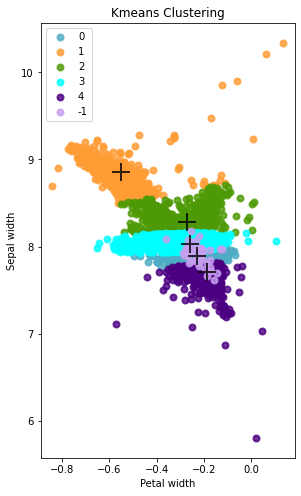

In [37]:
k_means = cluster.KMeans(n_clusters=5)
feature_1,_ = model(G,G.ndata["feature"])
feature_1 = feature_1.squeeze(1).squeeze(1).detach().numpy()
label = G.ndata['label'].reshape(-1)
k_means.fit(feature_1)
pred = k_means.labels_
gene_pred = torch.tensor(pred[idx]).reshape(-1,1)

y = label
colors = ['#4EACC5','#FF9C34','#4E9A06','#00ffff','indigo']
lw = 2
fig = plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(122)
for color ,i  in zip(colors,[0,1,2,3,4]):
    ax2.scatter(feature_1[k_means.labels_==i,0],feature_1[k_means.labels_==i,1],color=color,alpha = 0.8,lw=lw,label=i)

ax2.scatter(feature_1[idx,0],feature_1[idx,1],color='#c79fef',alpha = 0.8,lw=lw,label=-1)

for color ,i  in zip(colors,[0,1,2,3,4]):
    ax2.scatter(k_means.cluster_centers_[i,0],k_means.cluster_centers_[i,1],color='#000000', alpha=0.8, s=300,lw=lw, marker='+')
ax2.set_title('Kmeans Clustering')
ax2.set_xlabel('Petal width')
ax2.set_ylabel('Sepal width')
ax2.legend(loc = 'best',scatterpoints = 1)
plt.show()

In [42]:
firstlist = []
for i in range(len(pred)):
    if(pred[i]!=1 and pred[i]!=2):
        firstlist.append(i)
#print(firstlist)  
print(len(firstlist))

17932


In [53]:
model1 = GAT(1024,256)
#label = torch.ones(51,1)
opt = torch.optim.Adam(model1.parameters(),lr =0.0005)
model_loss = nn.BCELoss()
for epoch in range(100):
    model1.train()
    feature,pred_ = model1(G,G.ndata["feature"])
    pred_ = pred_.squeeze(1).squeeze(1)
    loss = model_loss(pred_,G.ndata['label'])
    loss.requires_grad_(True)
    opt.zero_grad()
    loss.backward()
    opt.step()

In [54]:
feature_2,_ = model1(G,G.ndata["feature"])
feature_2 = feature_2.squeeze(1).squeeze(1).detach().numpy()
label = G.ndata['label'].reshape(-1)

In [57]:
dims1=[]
for i in range(feature_2.shape[0]):
    dim =0
    if i not in idx:
        vec1 = feature_2[i]
        for j in idx:
            vec2 = feature_2[j]
            dim = dim + cosine(vec1,vec2)
    dims1.append(dim)

In [99]:
dims1 = np.array(dims1)
pre1 = np.argsort(dims1)
pre1_ = pre1[0:551]
pre1_0 = pre1[0:251]
pre1_0 = set(pre1_0)-set(idx)
print(pre1_)
pre1_ = set(pre1_)-set(idx)

[ 6681 16295  8333 11612 14685  6106  7504 11757  7615 13477  9647 10189
  9178 11827  4132  4120  9422  4117 14219 14217 12198 12199  2640 16606
 10072 13916   672  3695 10294 11415  2214  4504 15774  6503 17679  9575
 15909  3339  6478 12934  1227 11163 12872   802  7193 11269 11221  5284
  2010 14984  8774  1591   444  3657  2063  8454   923  9029   551  4668
  2360  9531  5905  4925  1145  5237  3127   991  1419   535  9577   335
  4631  1872  8067  4426  5306  1580   570   507   614  4701  6665  5673
   122   599   448 10453  3095  1936  6234  7764   669  1184  7834   941
  2083  4935  2954   811  9740  9215   635   992   348   480  2042  1004
  7496  2940   808  8318  1121   440  1441  8160   856  1524  1792 15492
   752  6590  5041  1349  1433 10514  5548   357  1405  2677   688  5272
   200   317   341  3284  4844  3489  6734   867  8317 12675  8196 10419
 12359   408  2069  2615  2120  7430  1713  2883  3041  1367  8366  5241
  7690  6072  2598  7043  4866  6163  8742  2184   

In [89]:
dims3=[]
for i in range(feature_2.shape[0]):
    dim =0
    if i not in idx:
        vec1 = feature_2[i]
        for j in idx:
            vec2 = feature_2[j]
            dim = dim + np.linalg.norm(vec1 - vec2)
    dims3.append(dim)
dims3 = np.array(dims3)


[ 6106  4120  2010 ... 19367 19381 19378]
[ 6106  4120  2010  7193  7504 15909  4132 14217  4117 14219 10189  6478
  8774  6503 10072 12199  4504  9575 12198 10294 15774  2214 12934 16606
  9178 14984 12872  7615 11269  2640 17679 11163  3695 13916  9422 11221
   802   672 11612 11415 13477  9647  3339 11757  1227  6681 14685  8333
 16295 11827  5284   941  4701  5237   923   155  8454  4583  5241   606
  8067  8357  1367   212  7764   500 12675  4896     7  1233  5105  1082
  4631  8222   669   316  1524   551 10472  9033  3657  7115  1697  6840
  1393  6862  8223   122  1158  3489  1580  7702  6616   105   148   662
  1682  9623  5484  4963  2954  8241   784  8341  1269   444   335  5041
  5299  1121  2314 10620 12358  8229  7559  7874  7682  7935 10058  9577
 10419   968  1632  7532  1025  6734   319   811  3617  5660  4672  1289
  2136  3361  4737  4924  2630  1530   991  1591  9591  4768  1249  6954
  7439    91   303  9546  7581   157 15492 10514  5885   735  3326  2946
  2719  4

In [100]:
pre2 = np.argsort(dims3)

pre2_ = pre2[0:551]
pre2_ = set(pre3_)-set(idx)
pre2_0 = pre2[0:251]
pre2_0 = set(pre2_0)-set(idx)

In [101]:
r1 = list(pre1_.intersection(pre2_))
r2 = list(pre1_0.intersection(pre2_0))
print(len(r1),len(r2))

258 68


In [102]:
new_dict = {v : k for k,v in protein_dict.items()}

In [103]:
target0 = []
target1 = []
for no in r2:
    target0.append(new_dict[no])
for no in r1:
    target1.append(new_dict[no])

In [105]:
print(target0)

['9606.ENSP00000367408', '9606.ENSP00000348381', '9606.ENSP00000356899', '9606.ENSP00000340944', '9606.ENSP00000469689', '9606.ENSP00000215375', '9606.ENSP00000166345', '9606.ENSP00000359976', '9606.ENSP00000416330', '9606.ENSP00000378769', '9606.ENSP00000411355', '9606.ENSP00000327959', '9606.ENSP00000285667', '9606.ENSP00000351905', '9606.ENSP00000265709', '9606.ENSP00000229239', '9606.ENSP00000223136', '9606.ENSP00000345230', '9606.ENSP00000262948', '9606.ENSP00000407213', '9606.ENSP00000381198', '9606.ENSP00000345772', '9606.ENSP00000245451', '9606.ENSP00000367292', '9606.ENSP00000451828', '9606.ENSP00000217964', '9606.ENSP00000281821', '9606.ENSP00000327214', '9606.ENSP00000407586', '9606.ENSP00000262160', '9606.ENSP00000366265', '9606.ENSP00000345672', '9606.ENSP00000233813', '9606.ENSP00000355966', '9606.ENSP00000324806', '9606.ENSP00000377936', '9606.ENSP00000284523', '9606.ENSP00000306163', '9606.ENSP00000354871', '9606.ENSP00000319060', '9606.ENSP00000360266', '9606.ENSP00000

In [127]:
file = open("info.txt","r")
file1 = open("target68.txt","w")
file2 = open("target258.txt","w")
line0 = file.readline()
file1.write(line0)
file2.write(line0)
lines = file.readlines()   
print(len(lines))
for line in lines:
    str = line[0:20]
    #print(line)
    #print(str)
    if(str in target0):
        file1.write(line)
    if(str in target1):
        file2.write(line)
file.close()
file1.close()
file2.close()

19566
9606.ENSP00000000233
9606.ENSP00000000412
9606.ENSP00000001008
9606.ENSP00000001146
9606.ENSP00000002125
9606.ENSP00000002165
9606.ENSP00000002596
9606.ENSP00000002829
9606.ENSP00000003084
9606.ENSP00000003100
9606.ENSP00000003302
9606.ENSP00000004531
9606.ENSP00000005178
9606.ENSP00000005226
9606.ENSP00000005257
9606.ENSP00000005260
9606.ENSP00000005284
9606.ENSP00000005286
9606.ENSP00000005340
9606.ENSP00000005386
9606.ENSP00000005587
9606.ENSP00000005995
9606.ENSP00000006015
9606.ENSP00000006053
9606.ENSP00000006275
9606.ENSP00000006526
9606.ENSP00000006658
9606.ENSP00000006724
9606.ENSP00000006777
9606.ENSP00000007390
9606.ENSP00000007414
9606.ENSP00000007699
9606.ENSP00000007722
9606.ENSP00000007735
9606.ENSP00000008391
9606.ENSP00000008527
9606.ENSP00000008938
9606.ENSP00000009041
9606.ENSP00000009105
9606.ENSP00000009530
9606.ENSP00000010299
9606.ENSP00000011292
9606.ENSP00000011473
9606.ENSP00000011619
9606.ENSP00000011653
9606.ENSP00000011898
9606.ENSP00000012049
9606.EN

9606.ENSP00000264245
9606.ENSP00000264246
9606.ENSP00000264249
9606.ENSP00000264254
9606.ENSP00000264255
9606.ENSP00000264257
9606.ENSP00000264260
9606.ENSP00000264265
9606.ENSP00000264276
9606.ENSP00000264279
9606.ENSP00000264313
9606.ENSP00000264316
9606.ENSP00000264318
9606.ENSP00000264335
9606.ENSP00000264344
9606.ENSP00000264346
9606.ENSP00000264350
9606.ENSP00000264360
9606.ENSP00000264363
9606.ENSP00000264376
9606.ENSP00000264377
9606.ENSP00000264380
9606.ENSP00000264381
9606.ENSP00000264382
9606.ENSP00000264387
9606.ENSP00000264389
9606.ENSP00000264399
9606.ENSP00000264400
9606.ENSP00000264414
9606.ENSP00000264424
9606.ENSP00000264428
9606.ENSP00000264431
9606.ENSP00000264433
9606.ENSP00000264434
9606.ENSP00000264436
9606.ENSP00000264444
9606.ENSP00000264451
9606.ENSP00000264454
9606.ENSP00000264463
9606.ENSP00000264474
9606.ENSP00000264497
9606.ENSP00000264498
9606.ENSP00000264499
9606.ENSP00000264501
9606.ENSP00000264515
9606.ENSP00000264538
9606.ENSP00000264552
9606.ENSP0000

9606.ENSP00000306864
9606.ENSP00000306866
9606.ENSP00000306869
9606.ENSP00000306881
9606.ENSP00000306884
9606.ENSP00000306887
9606.ENSP00000306888
9606.ENSP00000306894
9606.ENSP00000306900
9606.ENSP00000306906
9606.ENSP00000306918
9606.ENSP00000306920
9606.ENSP00000306968
9606.ENSP00000306974
9606.ENSP00000306983
9606.ENSP00000306991
9606.ENSP00000306997
9606.ENSP00000306999
9606.ENSP00000307004
9606.ENSP00000307014
9606.ENSP00000307023
9606.ENSP00000307041
9606.ENSP00000307046
9606.ENSP00000307078
9606.ENSP00000307093
9606.ENSP00000307126
9606.ENSP00000307129
9606.ENSP00000307130
9606.ENSP00000307132
9606.ENSP00000307134
9606.ENSP00000307142
9606.ENSP00000307143
9606.ENSP00000307159
9606.ENSP00000307164
9606.ENSP00000307181
9606.ENSP00000307183
9606.ENSP00000307188
9606.ENSP00000307197
9606.ENSP00000307199
9606.ENSP00000307208
9606.ENSP00000307214
9606.ENSP00000307234
9606.ENSP00000307235
9606.ENSP00000307240
9606.ENSP00000307241
9606.ENSP00000307259
9606.ENSP00000307260
9606.ENSP0000

9606.ENSP00000341219
9606.ENSP00000341236
9606.ENSP00000341243
9606.ENSP00000341247
9606.ENSP00000341268
9606.ENSP00000341280
9606.ENSP00000341282
9606.ENSP00000341289
9606.ENSP00000341291
9606.ENSP00000341292
9606.ENSP00000341324
9606.ENSP00000341342
9606.ENSP00000341344
9606.ENSP00000341346
9606.ENSP00000341351
9606.ENSP00000341360
9606.ENSP00000341361
9606.ENSP00000341364
9606.ENSP00000341368
9606.ENSP00000341412
9606.ENSP00000341422
9606.ENSP00000341442
9606.ENSP00000341483
9606.ENSP00000341489
9606.ENSP00000341490
9606.ENSP00000341524
9606.ENSP00000341528
9606.ENSP00000341539
9606.ENSP00000341549
9606.ENSP00000341550
9606.ENSP00000341551
9606.ENSP00000341562
9606.ENSP00000341564
9606.ENSP00000341565
9606.ENSP00000341581
9606.ENSP00000341584
9606.ENSP00000341597
9606.ENSP00000341610
9606.ENSP00000341625
9606.ENSP00000341637
9606.ENSP00000341640
9606.ENSP00000341657
9606.ENSP00000341658
9606.ENSP00000341662
9606.ENSP00000341677
9606.ENSP00000341680
9606.ENSP00000341684
9606.ENSP0000

9606.ENSP00000361728
9606.ENSP00000361731
9606.ENSP00000361735
9606.ENSP00000361745
9606.ENSP00000361746
9606.ENSP00000361748
9606.ENSP00000361755
9606.ENSP00000361761
9606.ENSP00000361765
9606.ENSP00000361769
9606.ENSP00000361770
9606.ENSP00000361777
9606.ENSP00000361780
9606.ENSP00000361784
9606.ENSP00000361785
9606.ENSP00000361788
9606.ENSP00000361791
9606.ENSP00000361795
9606.ENSP00000361800
9606.ENSP00000361803
9606.ENSP00000361811
9606.ENSP00000361813
9606.ENSP00000361818
9606.ENSP00000361820
9606.ENSP00000361824
9606.ENSP00000361834
9606.ENSP00000361842
9606.ENSP00000361845
9606.ENSP00000361850
9606.ENSP00000361852
9606.ENSP00000361855
9606.ENSP00000361857
9606.ENSP00000361860
9606.ENSP00000361866
9606.ENSP00000361867
9606.ENSP00000361868
9606.ENSP00000361871
9606.ENSP00000361875
9606.ENSP00000361883
9606.ENSP00000361892
9606.ENSP00000361894
9606.ENSP00000361895
9606.ENSP00000361900
9606.ENSP00000361914
9606.ENSP00000361915
9606.ENSP00000361917
9606.ENSP00000361918
9606.ENSP0000

9606.ENSP00000381699
9606.ENSP00000381703
9606.ENSP00000381717
9606.ENSP00000381736
9606.ENSP00000381740
9606.ENSP00000381758
9606.ENSP00000381760
9606.ENSP00000381768
9606.ENSP00000381773
9606.ENSP00000381775
9606.ENSP00000381782
9606.ENSP00000381785
9606.ENSP00000381793
9606.ENSP00000381795
9606.ENSP00000381821
9606.ENSP00000381823
9606.ENSP00000381824
9606.ENSP00000381840
9606.ENSP00000381844
9606.ENSP00000381857
9606.ENSP00000381859
9606.ENSP00000381876
9606.ENSP00000381895
9606.ENSP00000381928
9606.ENSP00000381932
9606.ENSP00000381937
9606.ENSP00000381949
9606.ENSP00000381956
9606.ENSP00000381958
9606.ENSP00000381968
9606.ENSP00000381970
9606.ENSP00000381981
9606.ENSP00000381984
9606.ENSP00000381992
9606.ENSP00000382000
9606.ENSP00000382004
9606.ENSP00000382021
9606.ENSP00000382026
9606.ENSP00000382030
9606.ENSP00000382058
9606.ENSP00000382071
9606.ENSP00000382083
9606.ENSP00000382086
9606.ENSP00000382090
9606.ENSP00000382091
9606.ENSP00000382097
9606.ENSP00000382101
9606.ENSP0000

9606.ENSP00000433560
9606.ENSP00000433597
9606.ENSP00000433623
9606.ENSP00000433642
9606.ENSP00000433646
9606.ENSP00000433664
9606.ENSP00000433681
9606.ENSP00000433712
9606.ENSP00000433757
9606.ENSP00000433761
9606.ENSP00000433773
9606.ENSP00000433816
9606.ENSP00000433847
9606.ENSP00000433919
9606.ENSP00000433933
9606.ENSP00000433967
9606.ENSP00000433999
9606.ENSP00000434024
9606.ENSP00000434033
9606.ENSP00000434034
9606.ENSP00000434045
9606.ENSP00000434142
9606.ENSP00000434241
9606.ENSP00000434279
9606.ENSP00000434343
9606.ENSP00000434359
9606.ENSP00000434364
9606.ENSP00000434399
9606.ENSP00000434412
9606.ENSP00000434435
9606.ENSP00000434442
9606.ENSP00000434466
9606.ENSP00000434480
9606.ENSP00000434508
9606.ENSP00000434515
9606.ENSP00000434516
9606.ENSP00000434552
9606.ENSP00000434570
9606.ENSP00000434602
9606.ENSP00000434614
9606.ENSP00000434655
9606.ENSP00000434676
9606.ENSP00000434724
9606.ENSP00000434727
9606.ENSP00000434729
9606.ENSP00000434830
9606.ENSP00000434847
9606.ENSP0000

序列预处理的特征聚类